##### From SAV to Love

# HW №6

## Введение в обработку естественного языка
### Урок 6. Классификация текста. Анализ тональности текста

### Практическое задание
### Взять ноутбук colab_text_classification_part1.ipynb который разбирали на занятии и добавить пункты которые мы пропустили

In [ ]:
from IPython.core.display import display, HTML, Image
display(HTML("<style>.container { width:77% !important; }</style>"))

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import sys

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

from collections import Counter

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers

In [ ]:
import nltk

from nltk.tag import BigramTagger, TrigramTagger, UnigramTagger
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

In [ ]:
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('maxent_ne_chunker')
# nltk.download('words')
# nltk.download('names')

In [ ]:
def eval_model(model, test_df):
    preds = model.predict(test_df['review'])
    accuracy = accuracy_score(test_df['is_positive'], preds)
    
    result = round(accuracy*100, 2)
    # print(f'Test accuracy = {result}%')
    
    return result

def convert(texts, word2idx, max_text_len):
    data = np.zeros((len(texts), max_text_len), dtype=np.int)

    for inx, text in enumerate(texts):
        result = []
        for word in text.split():
            if word in word2idx:
                result.append(word2idx[word])
        padding = [0]*(max_text_len - len(result))
        data[inx] = np.array(padding + result[-max_text_len:], dtype=np.int)

    return data

### Загрузка данных

In [ ]:
# !wget -O imdb.zip -qq --no-check-certificate "https://drive.google.com/uc?export=download&id=1vrQ5czMHoO3pEnmofFskymXMkq_u1dPc"
# !unzip imdb.zip
# !pip -q install eli5
# !pip -q install spacy
# !python -m spacy download en

In [ ]:
# Loading data
train_df = pd.read_csv("train.tsv", delimiter="\t")
test_df = pd.read_csv("test.tsv", delimiter="\t")

print(f'Train size = {len(train_df)}')
print(f'Test size = {len(test_df)}')

Train size = 25000
Test size = 25000


<a list of 230 Patch objects>

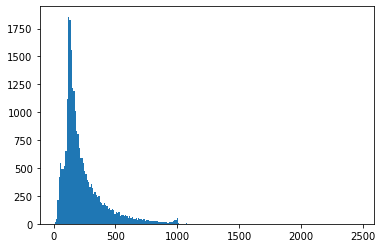

In [ ]:
hist = plt.hist(train_df['review'].apply(lambda text: len(text.split())), bins='auto')[2]
hist

In [ ]:
words_counter = Counter((word for text in train_df['review'] for word in text.lower().split()))
word2idx = {'':0, '<unk>':1}

for word, count in words_counter.most_common():
    if count < 10:
        break
    word2idx[word] = len(word2idx)

print('Words count', len(word2idx))

X_train = convert(train_df['review'], word2idx, 1000)
X_test = convert(test_df['review'], word2idx, 1000)

Words count 27299


In [ ]:
models = []

models.append(('CountVectorizer', CountVectorizer()))
models.append(('TfidfVectorizer', TfidfVectorizer()))
models.append(('HashingVectorizer', HashingVectorizer()))

In [ ]:
# Logistic Regression
results = []

for name, model in models:
    net = Pipeline([
        ('vectorizer', model),
        ('classifier', LogisticRegression())
    ])
    net.fit(train_df['review'], train_df['is_positive'])
    accuracy = eval_model(net, test_df)
    results.append((name, accuracy))

best_baseline01 = pd.DataFrame(results, columns = ['model','accuracy'])
best_baseline01.sort_values('accuracy', ascending=False)

,model,accuracy
1,TfidfVectorizer,88.32
0,CountVectorizer,86.31
2,HashingVectorizer,85.94


In [ ]:
models = []

models.append(('Net', Sequential([layers.Embedding(input_dim=len(word2idx), output_dim=64, input_shape=(X_train.shape[1],)),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(units=1, activation='sigmoid')
])))

In [ ]:
# tensorflow
results = []

for name, model in models:
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, train_df['is_positive'], batch_size=32, epochs=10, validation_data=(X_test, test_df['is_positive']))
    accuracy = model.evaluate(X_test, test_df['is_positive'])[1] * 100
    results.append((name, accuracy))

best_baseline03 = pd.DataFrame(results, columns = ['model','accuracy'])
best_baseline03.sort_values('accuracy', ascending=False)

Epoch 1/10
782/782 [==============================] - 47s 59ms/step - loss: 0.6873 - accuracy: 0.5650 - val_loss: 0.6414 - val_accuracy: 0.7717
Epoch 2/10
782/782 [==============================] - 45s 58ms/step - loss: 0.6096 - accuracy: 0.7563 - val_loss: 0.5300 - val_accuracy: 0.8053
Epoch 3/10
782/782 [==============================] - 44s 57ms/step - loss: 0.4986 - accuracy: 0.8141 - val_loss: 0.4500 - val_accuracy: 0.8349
Epoch 4/10
782/782 [==============================] - 46s 59ms/step - loss: 0.4161 - accuracy: 0.8501 - val_loss: 0.3974 - val_accuracy: 0.8507
Epoch 5/10
782/782 [==============================] - 43s 56ms/step - loss: 0.3616 - accuracy: 0.8719 - val_loss: 0.3624 - val_accuracy: 0.8631
Epoch 6/10
782/782 [==============================] - 44s 56ms/step - loss: 0.3212 - accuracy: 0.8852 - val_loss: 0.3444 - val_accuracy: 0.8626
Epoch 7/10
782/782 [==============================] - 43s 55ms/step - loss: 0.2950 - accuracy: 0.8955 - val_loss: 0.3258 - val_accuracy:

,model,accuracy
0,Net,88.047999


In [ ]:
final_result = pd.concat([best_baseline01, best_baseline03], axis=0)
final_result.sort_values('accuracy', ascending=False)

,model,accuracy
1,TfidfVectorizer,88.320000
0,Net,88.047999
0,CountVectorizer,86.310000
2,HashingVectorizer,85.940000


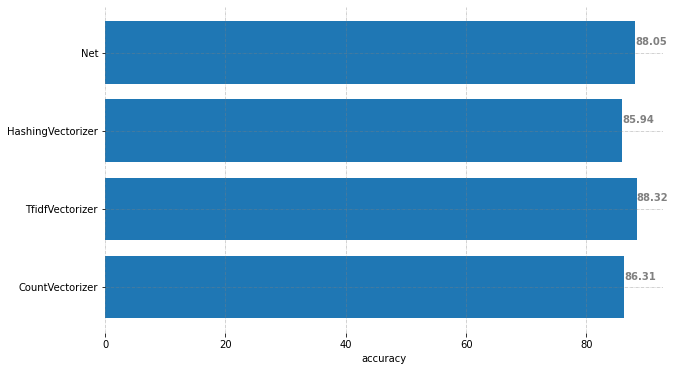

In [ ]:
x = final_result['model']
y = final_result['accuracy']

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(x, y)

# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)

# Add x, y gridlines
ax.grid(b=True, color='grey', linestyle='-.', linewidth=0.5, alpha=0.7)

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.01, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize=10, fontweight='bold',
             color='grey')

plt.xlabel('accuracy')
plt.show()

### 1. Посмотрите на токены если будут мусорные добавьте их в стоп слова и обучите заново  

In [ ]:
train_df['clean_review'] = train_df['review']
test_df['clean_review'] = test_df['review']
train_df.head()

,is_positive,review,clean_review
0,0,"Dreamgirls, despite its fistful of Tony wins i...","Dreamgirls, despite its fistful of Tony wins i..."
1,0,This show comes up with interesting locations ...,This show comes up with interesting locations ...
2,1,I simply love this movie. I also love the Ramo...,I simply love this movie. I also love the Ramo...
3,0,Spoilers ahead if you want to call them that.....,Spoilers ahead if you want to call them that.....
4,1,My all-time favorite movie! I have seen many m...,My all-time favorite movie! I have seen many m...


In [ ]:
train_df.tail()

,is_positive,review,clean_review
24995,1,"I am a big fan of the movie, but not for the u...","I am a big fan of the movie, but not for the u..."
24996,0,I'm not going to bother with a plot synopsis s...,I'm not going to bother with a plot synopsis s...
24997,0,This movie . . . I don't know. Why they would ...,This movie . . . I don't know. Why they would ...
24998,1,Saw this film on DVD yesterday and was gob-sma...,Saw this film on DVD yesterday and was gob-sma...
24999,0,This was a disappointment - none of the nuance...,This was a disappointment - none of the nuance...


In [ ]:
# Заменим html-сущности
import html
html.unescape(train_df['clean_review'])

0        Dreamgirls, despite its fistful of Tony wins i...
1        This show comes up with interesting locations ...
2        I simply love this movie. I also love the Ramo...
3        Spoilers ahead if you want to call them that.....
4        My all-time favorite movie! I have seen many m...
                               ...                        
24995    I am a big fan of the movie, but not for the u...
24996    I'm not going to bother with a plot synopsis s...
24997    This movie . . . I don't know. Why they would ...
24998    Saw this film on DVD yesterday and was gob-sma...
24999    This was a disappointment - none of the nuance...
Name: clean_review, Length: 25000, dtype: object

In [ ]:
# Изменим регистр на нижний с помощью .lower()
train_df['clean_review'] = train_df['clean_review'].apply(lambda x : x.lower())
test_df['clean_review'] = test_df['clean_review'].apply(lambda x : x.lower())

In [ ]:
# # Заменим пунктуацию на пробелы, используя re.sub() и паттерн r'[^\w\s]'
# train_df['clean_review'] = train_df['clean_review'].apply(lambda x : re.sub(r'[^\w\s]', ' ', x))
# test_df['clean_review'] = test_df['clean_review'].apply(lambda x : re.sub(r'[^\w\s]', ' ', x))

In [ ]:
# # Заменим спец. символы на пробелы, используя re.sub() и паттерн r'[^a-zA-Z0-9]'
# train_df['clean_review'] = train_df['clean_review'].apply(lambda x : re.sub(r'[^a-zA-Z0-9]', ' ', x))
# test_df['clean_review'] = test_df['clean_review'].apply(lambda x : re.sub(r'[^a-zA-Z0-9]', ' ', x))

In [ ]:
# # Заменим числа на пробелы, используя re.sub() и паттерн r'[^a-zA-Z]'
# train_df['clean_review'] = train_df['clean_review'].apply(lambda x : re.sub(r'[^a-zA-Z]', ' ', x))
# test_df['clean_review'] = test_df['clean_review'].apply(lambda x : re.sub(r'[^a-zA-Z]', ' ', x))

In [ ]:
# # Удалим из текста слова длиной в 1 символ
# train_df['clean_review'] = train_df['clean_review'].apply(lambda x : ' '.join([w for w in x.split() if len(w)>1]))
# test_df['clean_review'] = test_df['clean_review'].apply(lambda x : ' '.join([w for w in x.split() if len(w)>1]))

In [ ]:
#set stopwords to english
stop = set(stopwords.words('english'))
# print(stop)
train_df['clean_review'] = train_df['clean_review'].apply(lambda x : ' '.join([word for word in x.split() if word.lower() not in stop]))
test_df['clean_review'] = test_df['clean_review'].apply(lambda x : ' '.join([word for word in x.split() if word.lower() not in stop]))

In [ ]:
# create custom stop words list
my_stop_words = ['dvd', '<br />']
train_df['clean_review'] = train_df['clean_review'].apply(lambda x : ' '.join([word for word in x.split() if word.lower() not in my_stop_words]))
test_df['clean_review'] = test_df['clean_review'].apply(lambda x : ' '.join([word for word in x.split() if word.lower() not in my_stop_words]))

<a list of 242 Patch objects>

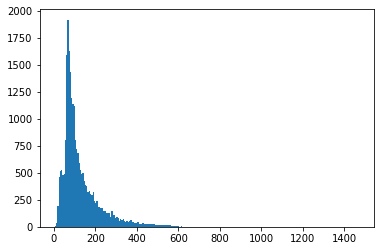

In [ ]:
hist2 = plt.hist(train_df['clean_review'].apply(lambda text: len(text.split())), bins='auto')[2]
hist2

In [ ]:
words_counter = Counter((word for text in train_df['clean_review'] for word in text.lower().split()))
word2idx = {'':0, '<unk>':1}

for word, count in words_counter.most_common():
    if count < 10:
        break
    word2idx[word] = len(word2idx)

print('Words count', len(word2idx))

X_train = convert(train_df['clean_review'], word2idx, 1000)
X_test = convert(test_df['clean_review'], word2idx, 1000)

Words count 27141


In [ ]:
models = []

models.append(('CountVectorizer', CountVectorizer()))
models.append(('TfidfVectorizer', TfidfVectorizer()))
models.append(('HashingVectorizer', HashingVectorizer()))

In [ ]:
# Logistic Regression
results = []

for name, model in models:
    net = Pipeline([
        ('vectorizer', model),
        ('classifier', LogisticRegression())
    ])
    net.fit(train_df['clean_review'], train_df['is_positive'])
    accuracy = eval_model(net, test_df)
    results.append((name, accuracy))

best_baseline11 = pd.DataFrame(results, columns = ['model','accuracy'])
best_baseline11.sort_values('accuracy', ascending=False)

,model,accuracy
1,TfidfVectorizer,87.62
2,HashingVectorizer,86.38
0,CountVectorizer,83.00


In [ ]:
models = []

models.append(('Net', Sequential([layers.Embedding(input_dim=len(word2idx), output_dim=64, input_shape=(X_train.shape[1],)),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(units=1, activation='sigmoid')
])))

In [ ]:
# tensorflow
results = []

for name, model in models:
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, train_df['is_positive'], batch_size=32, epochs=10, validation_data=(X_test, test_df['is_positive']))
    accuracy = model.evaluate(X_test, test_df['is_positive'])[1] * 100
    results.append((name, accuracy))

best_baseline13 = pd.DataFrame(results, columns = ['model','accuracy'])
best_baseline13.sort_values('accuracy', ascending=False)

Epoch 1/10
782/782 [==============================] - 41s 52ms/step - loss: 0.6891 - accuracy: 0.5516 - val_loss: 0.6603 - val_accuracy: 0.7525
Epoch 2/10
782/782 [==============================] - 40s 51ms/step - loss: 0.6322 - accuracy: 0.7737 - val_loss: 0.5578 - val_accuracy: 0.8241
Epoch 3/10
782/782 [==============================] - 41s 52ms/step - loss: 0.5143 - accuracy: 0.8409 - val_loss: 0.4654 - val_accuracy: 0.8470
Epoch 4/10
782/782 [==============================] - 40s 51ms/step - loss: 0.4217 - accuracy: 0.8660 - val_loss: 0.4091 - val_accuracy: 0.8551
Epoch 5/10
782/782 [==============================] - 40s 51ms/step - loss: 0.3522 - accuracy: 0.8877 - val_loss: 0.3651 - val_accuracy: 0.8682
Epoch 6/10
782/782 [==============================] - 40s 51ms/step - loss: 0.3085 - accuracy: 0.8983 - val_loss: 0.3385 - val_accuracy: 0.8728
Epoch 7/10
782/782 [==============================] - 40s 51ms/step - loss: 0.2765 - accuracy: 0.9042 - val_loss: 0.3203 - val_accuracy:

,model,accuracy
0,Net,88.348001


In [ ]:
final_result2 = pd.concat([best_baseline11, best_baseline13], axis=0)
final_result2.sort_values('accuracy', ascending=False)

,model,accuracy
0,Net,88.348001
1,TfidfVectorizer,87.620000
2,HashingVectorizer,86.380000
0,CountVectorizer,83.000000


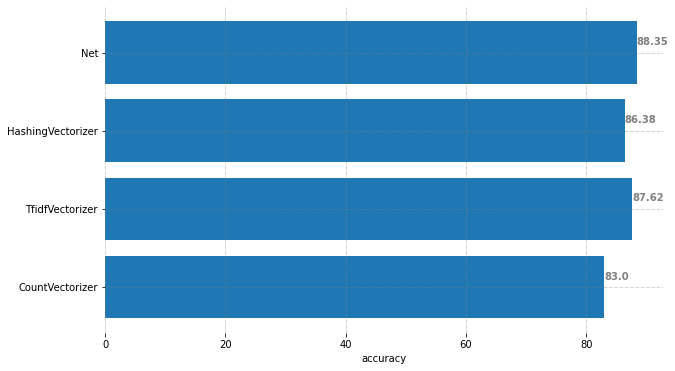

In [ ]:
x = final_result2['model']
y = final_result2['accuracy']

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(x, y)

# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)

# Add x, y gridlines
ax.grid(b=True, color='grey', linestyle='-.', linewidth=0.5, alpha=0.7)

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.01, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize=10, fontweight='bold',
             color='grey')

plt.xlabel('accuracy')
plt.show()

In [ ]:
final_results = pd.concat([final_result, final_result2], axis=1, 
                         keys=['baseline', 'pre-processing'])

In [ ]:
final_results

baseline                pre-processing           
               model   accuracy              model   accuracy
0    CountVectorizer  86.310000    CountVectorizer  83.000000
1    TfidfVectorizer  88.320000    TfidfVectorizer  87.620000
2  HashingVectorizer  85.940000  HashingVectorizer  86.380000
0                Net  88.047999                Net  88.348001

### 2. Проверьте повысилось ли качество на стандартных подходах при лемматизации

In [ ]:
train_df['lemmatized_review'] = train_df['review'].apply(lambda x : word_tokenize(x))
test_df['lemmatized_review'] = test_df['review'].apply(lambda x : word_tokenize(x))

In [ ]:
lemmatizer = WordNetLemmatizer()
train_df['lemmatized_review'] = train_df['lemmatized_review'].apply(lambda x : [lemmatizer.lemmatize(word, wordnet.VERB) for word in x])
test_df['lemmatized_review'] = test_df['lemmatized_review'].apply(lambda x : [lemmatizer.lemmatize(word, wordnet.VERB) for word in x])

In [ ]:
train_df['lemmatized_review'] = np.array([' '.join(x) for x in train_df['lemmatized_review']])
test_df['lemmatized_review'] = np.array([' '.join(x) for x in test_df['lemmatized_review']])

In [ ]:
train_df['lemmatized_review']

0        Dreamgirls , despite its fistful of Tony win i...
1        This show come up with interest locations as f...
2        I simply love this movie . I also love the Ram...
3        Spoilers ahead if you want to call them that ....
4        My all-time favorite movie ! I have see many m...
                               ...                        
24995    I be a big fan of the movie , but not for the ...
24996    I 'm not go to bother with a plot synopsis sin...
24997    This movie . . . I do n't know . Why they woul...
24998    Saw this film on DVD yesterday and be gob-smac...
24999    This be a disappointment - none of the nuance ...
Name: lemmatized_review, Length: 25000, dtype: object

<a list of 213 Patch objects>

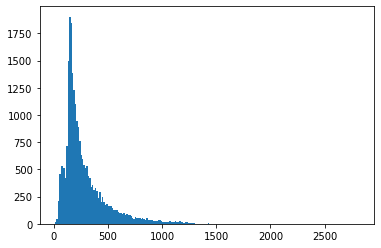

In [ ]:
hist3 = plt.hist(train_df['lemmatized_review'].apply(lambda text: len(text.split())), bins='auto')[2]
hist3

In [ ]:
words_counter = Counter((word for text in train_df['lemmatized_review'] for word in text.lower().split()))
word2idx = {'':0, '<unk>':1}

for word, count in words_counter.most_common():
    if count < 10:
        break
    word2idx[word] = len(word2idx)

print('Words count', len(word2idx))

X_train = convert(train_df['lemmatized_review'], word2idx, 1000)
X_test = convert(test_df['lemmatized_review'], word2idx, 1000)

Words count 18187


In [ ]:
models = []

models.append(('CountVectorizer', CountVectorizer()))
models.append(('TfidfVectorizer', TfidfVectorizer()))
models.append(('HashingVectorizer', HashingVectorizer()))

In [ ]:
# Logistic Regression
results = []

for name, model in models:
    net = Pipeline([
        ('vectorizer', model),
        ('classifier', LogisticRegression())
    ])
    net.fit(train_df['lemmatized_review'], train_df['is_positive'])
    accuracy = eval_model(net, test_df)
    results.append((name, accuracy))

best_baseline21 = pd.DataFrame(results, columns = ['model','accuracy'])
best_baseline21.sort_values('accuracy', ascending=False)

,model,accuracy
1,TfidfVectorizer,87.08
0,CountVectorizer,83.35
2,HashingVectorizer,83.27


In [ ]:
models = []

models.append(('Net', Sequential([layers.Embedding(input_dim=len(word2idx), output_dim=64, input_shape=(X_train.shape[1],)),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(units=1, activation='sigmoid')
])))

In [ ]:
# tensorflow
results = []

for name, model in models:
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, train_df['is_positive'], batch_size=32, epochs=10, validation_data=(X_test, test_df['is_positive']))
    accuracy = model.evaluate(X_test, test_df['is_positive'])[1] * 100
    results.append((name, accuracy))

best_baseline23 = pd.DataFrame(results, columns = ['model','accuracy'])
best_baseline23.sort_values('accuracy', ascending=False)

Epoch 1/10
782/782 [==============================] - 40s 50ms/step - loss: 0.6843 - accuracy: 0.5636 - val_loss: 0.6194 - val_accuracy: 0.7773
Epoch 2/10
782/782 [==============================] - 39s 50ms/step - loss: 0.5819 - accuracy: 0.7771 - val_loss: 0.5020 - val_accuracy: 0.7968
Epoch 3/10
782/782 [==============================] - 39s 50ms/step - loss: 0.4654 - accuracy: 0.8332 - val_loss: 0.4201 - val_accuracy: 0.8487
Epoch 4/10
782/782 [==============================] - 41s 52ms/step - loss: 0.3905 - accuracy: 0.8619 - val_loss: 0.3739 - val_accuracy: 0.8626
Epoch 5/10
782/782 [==============================] - 39s 50ms/step - loss: 0.3488 - accuracy: 0.8720 - val_loss: 0.3428 - val_accuracy: 0.8718
Epoch 6/10
782/782 [==============================] - 38s 49ms/step - loss: 0.3114 - accuracy: 0.8841 - val_loss: 0.3232 - val_accuracy: 0.8776
Epoch 7/10
782/782 [==============================] - 40s 51ms/step - loss: 0.2859 - accuracy: 0.8971 - val_loss: 0.3136 - val_accuracy:

,model,accuracy
0,Net,88.164002


In [ ]:
final_result3 = pd.concat([best_baseline21, best_baseline23], axis=0)
final_result3.sort_values('accuracy', ascending=False)

,model,accuracy
0,Net,88.164002
1,TfidfVectorizer,87.080000
0,CountVectorizer,83.350000
2,HashingVectorizer,83.270000


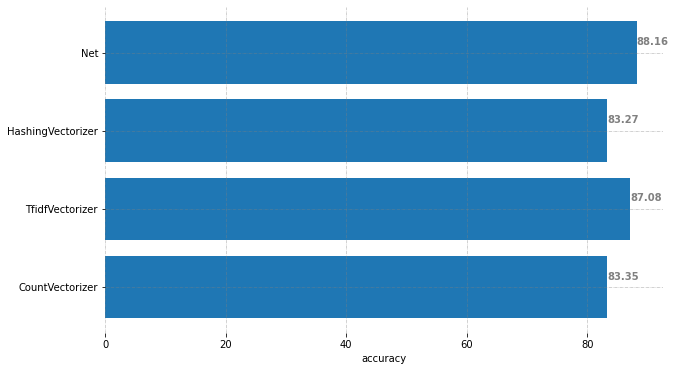

In [ ]:
x = final_result3['model']
y = final_result3['accuracy']

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(x, y)

# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)

# Add x, y gridlines
ax.grid(b=True, color='grey', linestyle='-.', linewidth=0.5, alpha=0.7)

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.01, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize=10, fontweight='bold',
             color='grey')

plt.xlabel('accuracy')
plt.show()

In [ ]:
final_results = pd.concat([final_result, final_result2, final_result3], axis=1, 
                         keys=['baseline', 'pre-processing', 'lemmatize'])

In [ ]:
final_results

baseline             ...          lemmatize           
               model   accuracy  ...              model   accuracy
0    CountVectorizer  86.310000  ...    CountVectorizer  83.350000
1    TfidfVectorizer  88.320000  ...    TfidfVectorizer  87.080000
2  HashingVectorizer  85.940000  ...  HashingVectorizer  83.270000
0                Net  88.047999  ...                Net  88.164002

[4 rows x 6 columns]

### 3. Удалите из текстов какие-то из сущностей(не удалите а замените их тегом). Запустите классификатор.

In [ ]:
# for id, text in enumerate(train_df['review']):
#     # names = {(' '.join(c[0] for c in chunk), chunk.label() ) for chunk in nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(text))) if hasattr(chunk, 'label') and chunk.label() == 'PERSON'}
#     chunks = nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(text)))
#     names = {' '.join(c[0] for c in chunk) for chunk in chunks if hasattr(chunk, 'label') and chunk.label() == 'PERSON'}
#     for name in names:
#         train_df['person_review'] = train_df['review'].str.replace(name,'PERSONALITY')

In [ ]:
# for id, text in enumerate(test_df['review']):
#     # names = {(' '.join(c[0] for c in chunk), chunk.label() ) for chunk in nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(text))) if hasattr(chunk, 'label') and chunk.label() == 'PERSON'}
#     chunks = nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(text)))
#     names = {' '.join(c[0] for c in chunk) for chunk in chunks if hasattr(chunk, 'label') and chunk.label() == 'PERSON'}
#     for name in names:
#         test_df['person_review'] = test_df['review'].str.replace(name,'PERSONALITY')

In [ ]:
words_counter = Counter((word for text in train_df['person_review'] for word in text.lower().split()))
word2idx = {'':0, '<unk>':1}

for word, count in words_counter.most_common():
    if count < 10:
        break
    word2idx[word] = len(word2idx)

print('Words count', len(word2idx))

X_train = convert(train_df['person_review'], word2idx, 1000)
X_test = convert(test_df['person_review'], word2idx, 1000)

Words count 27298


In [ ]:
models = []

models.append(('CountVectorizer', CountVectorizer()))
models.append(('TfidfVectorizer', TfidfVectorizer()))
models.append(('HashingVectorizer', HashingVectorizer()))

In [ ]:
# Logistic Regression
results = []

for name, model in models:
    net = Pipeline([
        ('vectorizer', model),
        ('classifier', LogisticRegression())
    ])
    net.fit(train_df['person_review'], train_df['is_positive'])
    accuracy = eval_model(net, test_df)
    results.append((name, accuracy))

best_baseline31 = pd.DataFrame(results, columns = ['model','accuracy'])
best_baseline31.sort_values('accuracy', ascending=False)

,model,accuracy
1,TfidfVectorizer,88.32
0,CountVectorizer,86.64
2,HashingVectorizer,85.94


In [ ]:
models = []

models.append(('Net', Sequential([layers.Embedding(input_dim=len(word2idx), output_dim=64, input_shape=(X_train.shape[1],)),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(units=1, activation='sigmoid')
])))

In [ ]:
# tensorflow
results = []

for name, model in models:
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, train_df['is_positive'], batch_size=32, epochs=10, validation_data=(X_test, test_df['is_positive']))
    accuracy = model.evaluate(X_test, test_df['is_positive'])[1] * 100
    results.append((name, accuracy))

best_baseline33 = pd.DataFrame(results, columns = ['model','accuracy'])
best_baseline33.sort_values('accuracy', ascending=False)

Epoch 1/10
782/782 [==============================] - 42s 52ms/step - loss: 0.6877 - accuracy: 0.5618 - val_loss: 0.6422 - val_accuracy: 0.7679
Epoch 2/10
782/782 [==============================] - 41s 53ms/step - loss: 0.6097 - accuracy: 0.7516 - val_loss: 0.5308 - val_accuracy: 0.8038
Epoch 3/10
782/782 [==============================] - 40s 51ms/step - loss: 0.4995 - accuracy: 0.8116 - val_loss: 0.4506 - val_accuracy: 0.8352
Epoch 4/10
782/782 [==============================] - 39s 50ms/step - loss: 0.4158 - accuracy: 0.8553 - val_loss: 0.3991 - val_accuracy: 0.8530
Epoch 5/10
782/782 [==============================] - 39s 50ms/step - loss: 0.3638 - accuracy: 0.8682 - val_loss: 0.3641 - val_accuracy: 0.8612
Epoch 6/10
782/782 [==============================] - 39s 50ms/step - loss: 0.3267 - accuracy: 0.8828 - val_loss: 0.3489 - val_accuracy: 0.8579
Epoch 7/10
782/782 [==============================] - 40s 51ms/step - loss: 0.2987 - accuracy: 0.8918 - val_loss: 0.3364 - val_accuracy:

,model,accuracy
0,Net,87.427998


In [ ]:
final_result4 = pd.concat([best_baseline31, best_baseline33], axis=0)
final_result4.sort_values('accuracy', ascending=False)

,model,accuracy
1,TfidfVectorizer,88.320000
0,Net,87.427998
0,CountVectorizer,86.640000
2,HashingVectorizer,85.940000


In [ ]:
final_results = pd.concat([final_result, final_result2, final_result3, final_result4], axis=1, 
                         keys=['baseline', 'pre-processing', 'lemmatize', 'tag'])

In [ ]:
final_results

baseline             ...                tag           
               model   accuracy  ...              model   accuracy
0    CountVectorizer  86.310000  ...    CountVectorizer  86.640000
1    TfidfVectorizer  88.320000  ...    TfidfVectorizer  88.320000
2  HashingVectorizer  85.940000  ...  HashingVectorizer  85.940000
0                Net  88.047999  ...                Net  87.427998

[4 rows x 8 columns]

### 4. Поэкспериментируйте с подходом с сеточками на разных данных (с удалёнными сущностями или без)